# By: Thomas Isola
## Class: PUI 2018
## HW #12 Assignment 2

In [1]:
import pandas as pd
import zipfile
import os
import pylab as pl
import urllib
import geopandas as gpd
import sklearn.cluster
from scipy.cluster.vq import kmeans2
from sklearn import mixture

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Check if PUIdata exists
import os
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/ti582/PUIdata


In [3]:
# Download the Census data
files = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08',
        '09', '10', '11', '12', '13', '14']
i = 0
for item in files:
    url = 'https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp' + '%s'%files[i] + 'totals.zip?raw=true'
    urllib.request.urlretrieve(url, 'zbp' + '%s'%files[i] + 'totals.zip')
    file = 'zbp' + '%s'%files[i] + 'totals.zip'
    unzippedfile = zipfile.ZipFile(file, 'r')
    unzippedfile.extractall(os.getenv('PUIDATA'))
    i = i + 1

In [4]:
# Download the NYC zipcodes shapefile
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.request.urlretrieve(url, 'nyczipsshp.zip')
unzipped = zipfile.ZipFile('nyczipsshp.zip', 'r')
unzipped.extractall(os.getenv('PUIDATA'))

In [5]:
# Printing information about the NYC zipcodes
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [6]:
# Display the NYC zipcodes data
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [7]:
# Remove unnecessary columns from NYC Zip Codes
nyczipsshp2 = nyczipsshp[['ZIPCODE','SHAPE_AREA','SHAPE_LEN','geometry']]
nyczipsshp2.loc[:,'ZIPCODE'] = nyczipsshp2['ZIPCODE'].astype('int64')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
# Convert the census data to dataframes and place them in a dictionary
ind = ['94', '95', '96', '97', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']
d = {}
for item in ind:
    d[item]= pd.read_csv(os.getenv('PUIDATA') + '/zbp' + '%s'%item + 'totals.txt')
    placeholder = d[item]
    placeholder = placeholder[['zip','est']]
    placeholder.rename(columns={'zip':'ZIPCODE'}, inplace=True)
    d[item] = placeholder

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [9]:
# Continue converting the census data to dataframes and placing them in a dictionary
ind2 = ['98', '99', '00', '01', '02']
for item in ind2:
    d[item]= pd.read_csv(os.getenv('PUIDATA') + '/zbp' + '%s'%item + 'totals.txt')
    placeholder = d[item]
    placeholder = placeholder[['ZIP','EST']]
    placeholder.rename(columns={'ZIP':'ZIPCODE','EST':'est'}, inplace=True)
    d[item] = placeholder

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [10]:
# Merge the Census and NYC Zipcodes data
for item in d.keys():
    nyczipsshp2 = nyczipsshp2.merge(d[item], on='ZIPCODE')
    nyczipsshp2.rename(index=str, columns={'est':'est'+'%s'%item}, inplace=True)
nyczipsshp2 = nyczipsshp2[['ZIPCODE','SHAPE_AREA','SHAPE_LEN','geometry','est94','est95','est96','est97',
                           'est98','est99','est00','est01','est02','est03','est04','est05','est06','est07',
                          'est08','est09','est10','est11','est12','est13','est14']]
nyczipsshp2.head()

,ZIPCODE,SHAPE_AREA,SHAPE_LEN,geometry,est94,est95,est96,est97,est98,est99,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,11436,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",51,50,53,51,51,58,...,82,80,84,90,92,98,101,95,99,109
1,11213,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",406,420,433,456,476,473,...,556,565,556,592,621,675,674,726,755,772
2,11212,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,494,502,527,519,541,...,587,570,587,602,647,699,713,721,731,752
3,11225,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",381,387,388,410,416,409,...,491,499,514,520,543,580,597,623,673,696
4,11218,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",985,1015,1049,1075,1118,1149,...,1332,1331,1377,1397,1457,1474,1523,1605,1687,1736


In [11]:
# Create a new dataframe without the geometric info
columns = list(range(4,25))
columns.insert(0,0)
cleancsb = nyczipsshp2.iloc[:, columns]
cleancsb.drop('ZIPCODE', axis=1, inplace=True)
cleancsb = pd.DataFrame(cleancsb)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# Standardize the new dataframe
vals = ( (cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1) ).T
vals.reset_index(inplace=True)
vals.drop(['index'], axis=1, inplace=True)

In [13]:
# Check that the mean is 0
print(vals.mean(1))

0     -3.595008e-16
1     -1.268826e-16
2      4.652363e-16
3     -1.903239e-16
4     -2.537653e-16
5      7.084280e-16
6     -2.008975e-16
7     -3.912214e-16
8      2.537653e-16
9      4.863834e-16
10     4.229421e-17
11    -1.448577e-15
12     6.026925e-16
13     8.141636e-16
14     1.903239e-16
15     1.903239e-16
16    -5.286776e-17
17    -1.173664e-15
18    -1.173664e-15
19    -1.173664e-15
20     3.595008e-16
21     1.163091e-16
22     6.132661e-16
23     1.480297e-16
24    -5.921189e-16
25    -6.132661e-16
26    -4.335157e-16
27     5.709718e-16
28    -7.612958e-16
29    -2.003688e-15
           ...     
213   -2.580401e-16
214    1.903239e-16
215    8.458842e-17
216    0.000000e+00
217    1.453863e-16
218    1.268826e-16
219    6.608470e-16
220    3.172066e-17
221    7.930164e-17
222   -6.714206e-16
223    4.652363e-16
224    2.326182e-16
225    4.229421e-16
226   -3.119198e-16
227   -1.586033e-16
228    2.326182e-16
229    1.797504e-16
230   -6.132661e-16
231    1.586033e-17


The mean values are all very close to 0, which is what is desired.

In [14]:
# Check the shape of the mean
print(vals.mean(1).shape)

(243,)


The shape matches the number of zipcodes, which is desired.

In [15]:
# Check that the standard deviation is 0
print(vals.std(1))

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
      ... 
213    1.0
214    1.0
215    1.0
216    1.0
217    1.0
218    1.0
219    1.0
220    1.0
221    1.0
222    1.0
223    1.0
224    1.0
225    1.0
226    1.0
227    1.0
228    1.0
229    1.0
230    1.0
231    1.0
232    1.0
233    1.0
234    1.0
235    1.0
236    1.0
237    1.0
238    1.0
239    1.0
240    1.0
241    1.0
242    1.0
dtype: float64


The standard deviation values are all 1, which is desired.

In [16]:
# Check the shape of the standard deviation
print(vals.std(1).shape)

(243,)


The shape matches the number of zipcodes, which is desired.

## Clustering Method 1: KMeans

In [17]:
# Perform the clustering with kmeans
nc = 5
km = sklearn.cluster.KMeans(n_clusters=nc, random_state=300).fit(vals)

5 clusters seems to be a reasonable choice.

In [18]:
# Add labels column to dataframe
kmlabels = pd.DataFrame(km.labels_, columns=['labels'])
vals2 = pd.concat((vals, kmlabels), axis=1)

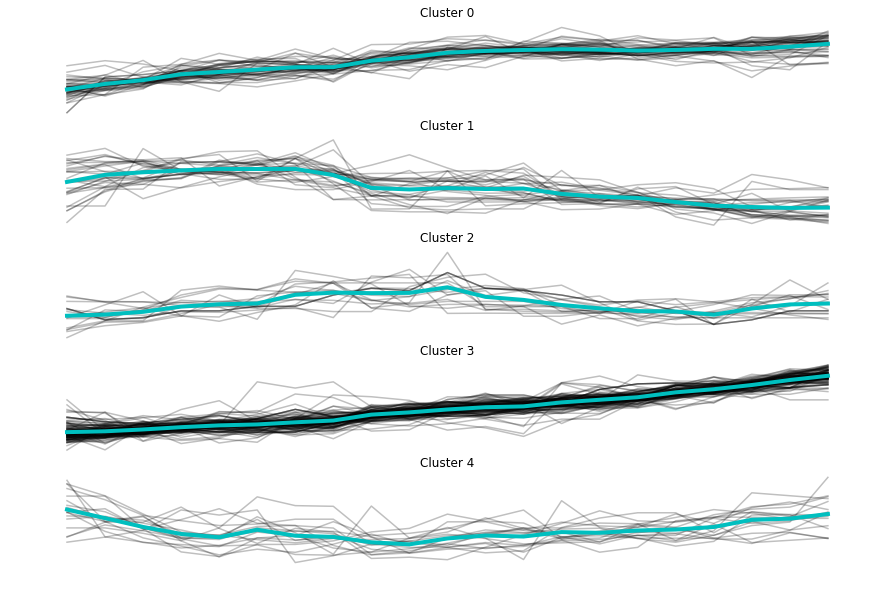

In [19]:
figs, ax = pl.subplots(5, 1, figsize=(15,10))
for i in range(5):
    center = vals2[vals2.loc[:,'labels'] == i].drop(['labels'], axis=1)
    for j in center.T:
        ax[i].plot(range(21), center.loc[j], 'k-', alpha=0.25)
        ax[i].axis('off')
        ax[i].set_title('Cluster %s'%i)
    ax[i].plot(range(21), center.mean(0), 'c-', linewidth=4)

**Figure 1**: The above is a plot of the cluster centers overlayed on top of each time series using hard clustering (K-means). The cluster center is shown in a thick cyan line and each time series is shown as semi-transparent black lines. As shown above, the clusters are grouped quite nicely given that there is not much spread outside of the average and the average appears to be well-centered for each cluster. In terms of economic trends: clusters 0 and 3 show an upward trend of the number of establishments over time;  cluster 1 shows a downward trend over time; cluster 2 shows an increase followed by a decrease and an increase and cluster 4 shows a positive parabolic trend. 

In [20]:
# Reset the index
nyczipsshp3 = nyczipsshp2.reset_index()
nyczipsshp3.drop(['index'], axis=1, inplace=True)

In [21]:
# Add KMeans labels to the GeoDataFrame
nyczipsshp3['labels'] = kmlabels

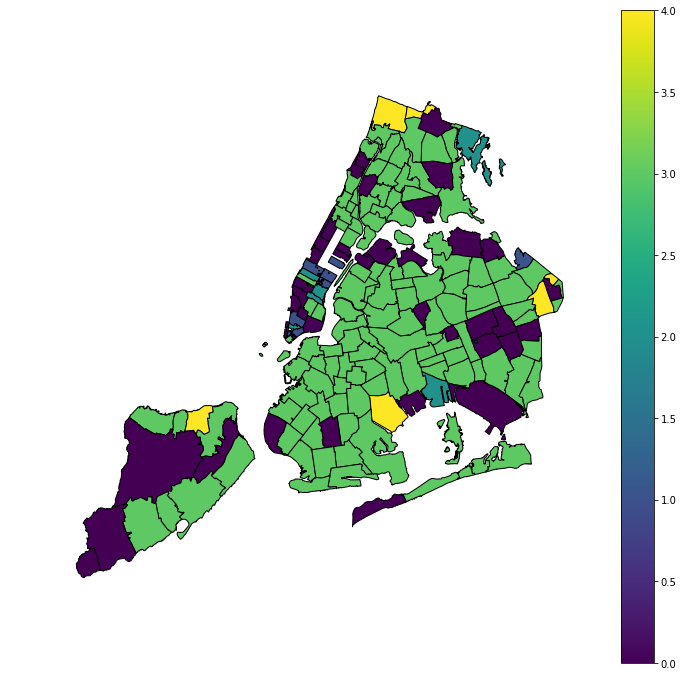

In [22]:
# Plot the results of the KMeans clustering on the NYC map
plot1 = nyczipsshp3.plot(column='labels',figsize=(12,12),cmap='viridis',alpha=1,
                          linewidth=1, edgecolor='black', legend=True)
plot1.axis('off');

**Figure 2**: Above is a plot of the 5 clusters of the number of establishments in NYC using hard clustering (K-means). The establishments data comes from the US Census and the map of NYC comes from NYC Open Data. The legend on the right hand side of the plot shows the colors that correspond to each cluster. Cluster 0, at the bottom, is purple, while cluster 4, at the top, is yellow. The plot shows that, in general, clusters 0, 2, and 4 are not geographically close to each other while clusters 1 and 3 are. Clusters 0 and 3 represent most of New York City. This is reasonable given that those are the two clusters that represent increasing numbers of establishments over time and New York City has grown in population over time. It is interesting to note that there appears to be a group of zipcodes representing cluster 1 in midtown Manhattan and that cluster 1 is a general decrease in the number of establishments over time. One would think that Manhattan would have an increasing number of establishments over time, which is why this is intriguing.

## Clustering Method 2: Agglomerative Clustering

In [23]:
# Perform the clustering with agglomerative
nc = 5
agc = sklearn.cluster.AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)

In [24]:
# Add labels column to dataframe
agclabels = pd.DataFrame(agc.labels_, columns=['labels'])
valsagc = pd.concat((vals, agclabels), axis=1)

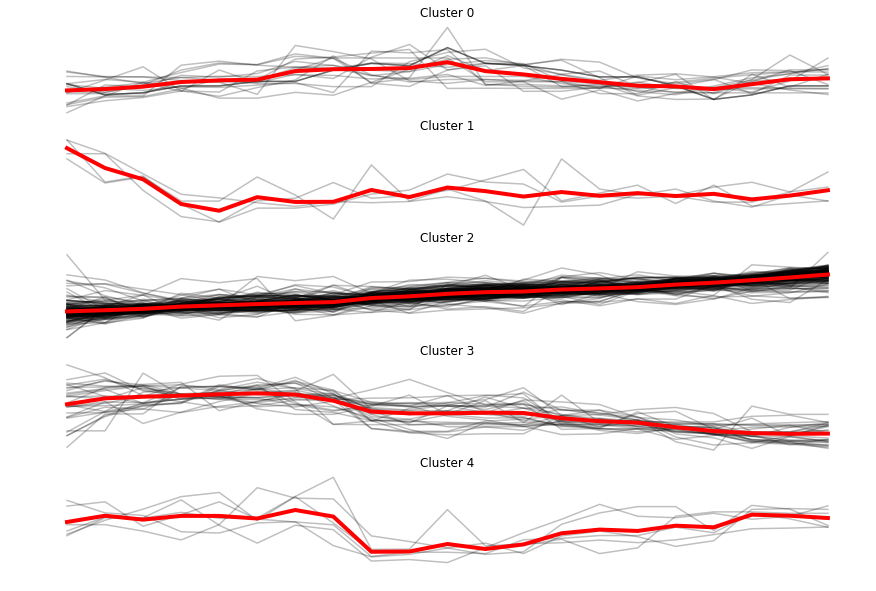

In [25]:
figs, ax = pl.subplots(nc, 1, figsize=(15,10))
for i in range(nc):
    center = valsagc[valsagc.loc[:,'labels'] == i].drop(['labels'], axis=1)
    for j in center.T:
        ax[i].plot(range(21), center.loc[j], 'k-', alpha=0.25)
        ax[i].axis('off')
        ax[i].set_title('Cluster %s'%i)
    ax[i].plot(range(21), center.mean(0), 'r-', linewidth=4)

**Figure 3**: The above is a plot of the cluster centers overlayed on top of each time series using hierarchical clustering (Agglomerative). The cluster center is shown in a thick red line and each time series is shown as semi-transparent black lines. As shown above, the clusters are grouped quite nicely given that there is not much spread outside of the average and the average appears to be well-centered for each cluster. Cluster 2 appears to contain the most time series while cluster 1 and cluster 4 contain the fewest number of time series. This is different from the previous clustering method (K-means) which was more evenly distributed between the clusters. In terms of economic trends: cluster 1 shows an increase then decrease then increase in number of establishments; cluster 1 shows a steep decrease followed by a plateau; cluster 2 shows a consistent increase; cluster 3 shows a consistent decrease; and cluster 4 shows a plateau followed by a sharp decrease and then a general increase. These are slightly different patterns than those found using clustering method 1 (K-means).

In [26]:
# Reset the index
nyczipsshpagc = nyczipsshp2.reset_index()
nyczipsshpagc.drop(['index'], axis=1, inplace=True)

In [27]:
# Add KMeans labels to the GeoDataFrame
nyczipsshpagc['labels'] = agclabels

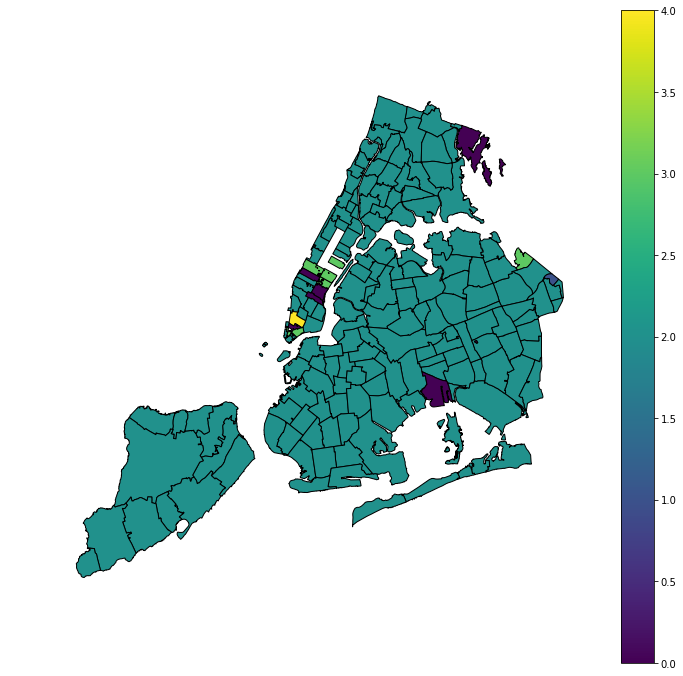

In [28]:
# Plot the results of the Agglomerative clustering on the NYC map
plot2 = nyczipsshpagc.plot(column='labels',figsize=(12,12),cmap='viridis',alpha=1,
                          linewidth=1, edgecolor='black', legend=True)
plot2.axis('off');

**Figure 4**: Above is a plot of the 5 clusters of the number of establishments in NYC using hierarchical clustering (Agglomerative). The establishments data comes from the US Census and the map of NYC comes from NYC Open Data. The legend on the right hand side of the plot shows the colors that correspond to each cluster. Cluster 0, at the bottom, is purple, while cluster 4, at the top, is yellow. The plot shows that, in general, the zipcodes in cluster 0 are not geographically close to each other while the zipcodes in clusters 2 and 3 are. Cluster 2 represents most of NYC while cluster 3 is centered mostly in midtown Manhattan. This is a similar finding to the result of clustering method 1 (K-means), which werre that the generally increasing slope cluster (cluster 2 in this case) represents the majority of New York City and that the generally decreasing slope cluster is found mostly in Midtown Manhattan. 

### Comparison between Clustering Method 1 (K-means) and Clustering Method 2 (Agglomerative):
I used 5 clusters for both clustering methods.  

_Differences_:
- The K-means clustering method had more evenly distributed clusters (meaning there was about an equal number of time series in each cluster) while the Agglomerative clustering method had less evenly distributed clusters (meaning there were clusters with high number of time series and clusters with small numbers of time series). 
- The Agglomerative clustering method produced more "complex" looking cluster center plots compared to K-means. K-means shows simpler cluster center plots that were either steadily increasing, steadily decreasing, or parabolic while Agglomerative produced simple plots as well as more complex ones with steep changes (such as cluster 1 and cluster 4). 

_Similarities_:
- They both showed that NYC is mostly one cluster (cluster 3 for K-means and cluster 2 for Agglomerative) which illustrates that NYC has had a general trend of increasing numbers of establishments over time for the past 20 or so years.  

Overall, it is tough to say which is better or worse. I think that each may have its own advantages depending on what purpose you are using them for. 